In [2]:
!pip install -q tensorflow==2.17.0

ERROR: Could not find a version that satisfies the requirement tensorflow==2.7.0 (from versions: 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.7.0

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import copy
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.offsetbox import (
    TextArea, 
    DrawingArea, 
    OffsetImage, 
    AnnotationBbox
)


TYPE_FLOAT = np.float32     # alias of Python float

# Plot

In [4]:
def getImage(path, zoom=0.4, height=1, width=1):
    img = OffsetImage(plt.imread(path), zoom=zoom)
    img.set_height(height )
    img.set_width(width)
    img.set_label("hoge")
    img.set_animated(True)
    return img

In [5]:
def plot_fish_neighbor_locations(ax):
    for index in range(0, len(X_fish_neighbor_locations)):
        ax.add_artist(AnnotationBbox(
            getImage(fish_neighbor_locations_img_paths[index]), 
            (X_fish_neighbor_locations[index,0], X_fish_neighbor_locations[index,1]), 
            frameon=False
        ))
        
def plot_fish(ax, coordinate, arrow=False):
    ax.add_artist(AnnotationBbox(
        getImage('../image/fish.png'), 
        coordinate, 
        frameon=False
    ))
    if arrow:
        ax.arrow(x=0, y=0, dx=coordinate[0], dy=coordinate[1], color='b', width=0.01, alpha=0.3, animated=True)

In [6]:
def plot_cow_neighbor_locations(ax):
    for index in range(0, len(X_cow_neighbor_locations)):
        ax.add_artist(AnnotationBbox(
            getImage(cow_neighbor_locations_img_paths[index]), 
            (X_cow_neighbor_locations[index,0], X_cow_neighbor_locations[index,1]), 
            frameon=False
        ))
        
def plot_cow(ax, coordinate, arrow=False):
    coordinate = np.avg()
    ax.add_artist(AnnotationBbox(
        getImage('../image/cow.png'), 
        coordinate, 
        frameon=False
    ))
    if arrow:
        ax.arrow(x=0, y=0, dx=coordinate[0], dy=coordinate[1], color='r', width=0.03)

In [7]:
def layout(location):
    fig, ax = plt.subplots(figsize=(10, 10)) 

    # For the same scaling
    # https://matplotlib.org/stable/gallery/subplots_axes_and_figures/axis_equal_demo.html
    ax.axis('equal')
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_position('zero')
    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_visible(False)

    ax.set_xticks(np.linspace(-3, 3, 7))
    ax.set_yticks(np.linspace(-3, 3, 7))
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)

    # Fish alikes
    plot_fish_neighbor_locations(ax)
    plot_fish(ax, location, True)

    # Cow alikes
    plot_cow_neighbor_locations(ax)


    ax.tick_params(axis='x', colors='red')
    ax.tick_params(axis='y', colors='blue')
    ax.grid()
    
    return fig, ax

In [11]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def binary_cross_entropy_log_loss(X, T):
    """Binary cross entropy log loss function
    Args: 
        X: Signal from sigmoid/logistic function
        T: Label
    """
    # 1/Z where Z = sigmoid(X) = (1/1 + np.exp(-X))
    Z1 = TYPE_FLOAT(1.0) + np.exp(-X, dtype=TYPE_FLOAT)    
    J = np.multiply((TYPE_FLOAT(1.0) - T), X) + np.log(Z1)
    #J = np.squeeze(J, axis=-1)    # Shape from (N,M) to (N,)
    return J


@tf.function
def tf_forward_propagate(w, X):
    """Loss function to measure how far the w is away from its neighbours X 
    to which it conceptually belongs to. 
    
    w="fish" is conceptually belngs to the neighbor group of X:[sea, soy, japan, sushi].
    The farther w is away from those neighbor X, the more the loss is.
    
    Args:
        w: vector to measure the distance from the neighbors X.
        X:  array of vectors representing the neighbors of shape (N, D)
    Returns: scala loss value L
    """
    # --------------------------------------------------------------------------------
    # Labels
    # --------------------------------------------------------------------------------
    T = [0] * len(X)

    # --------------------------------------------------------------------------------
    # Inner product X@W to measure similarities.
    # --------------------------------------------------------------------------------
    Y = tf.einsum("d,nd->n", w, X)

    # --------------------------------------------------------------------------------
    # Logistic function
    # --------------------------------------------------------------------------------
    Z = tf.math.sigmoid(Y)

    # --------------------------------------------------------------------------------
    # Binary cross entropy log loss
    # --------------------------------------------------------------------------------
    L = tf.keras.losses.BinaryCrossentropy(from_logits=True)(T, Z)
    
    return L


def np_gradient(w, X, T):
    """Gradient of the system (@ -> sigmoid -> loss)"""
    Y = np.einsum("d,nd->n", w, X)
    Z = sigmoid(Y)
    G = np.einsum("nd,n->d", X, (Z-T))
    assert G.shape == w.shape
    return G

# Inner product for similiarity

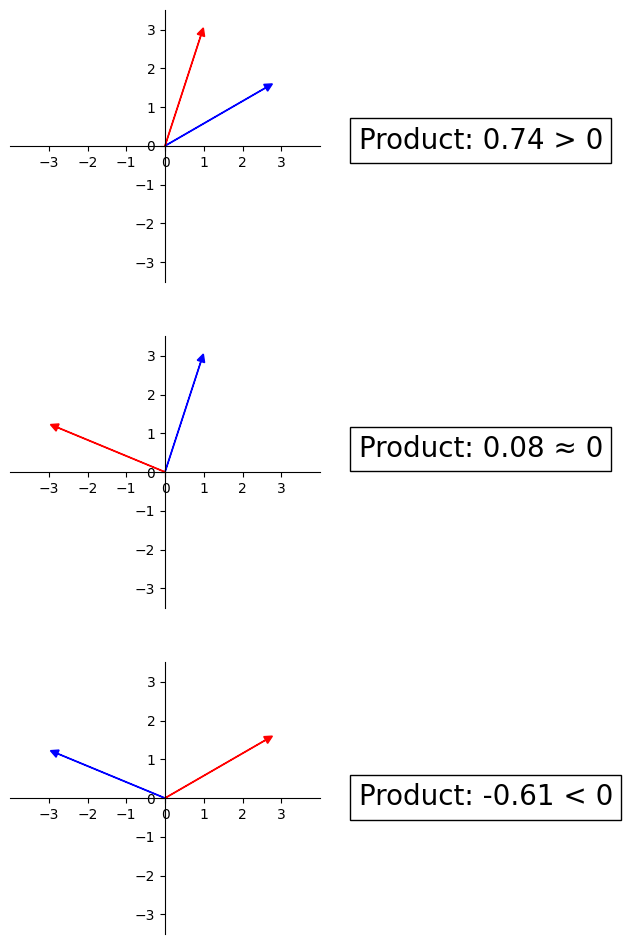

In [12]:
thetas = [
    np.pi / 6,
    np.pi / 2.5,
    np.pi * (7/8),
    
]
V = [
    (np.cos(theta), np.sin(theta)) for theta in thetas
]
N = len(thetas)

fig, axes = plt.subplots(3, figsize=(4, 12)) 
for i in range(0, N):

    # --------------------------------------------------------------------------------
    # Calculate the Product of the two Vectors
    # --------------------------------------------------------------------------------
    X = V[i]
    Y = V[(i+1) % N]
    P = np.inner(X, Y)      # <----- Product of vectors
    
    if (i%N) ==0:
        message = f"Product: {np.round(P, 2)} > 0"
    elif (i%N) == 1:
        message = f"Product: {np.round(P, 2)} ≈ 0"
    else:
        message = f"Product: {np.round(P, 2)} < 0"

    ax = axes[i]
    ax.axis('equal')
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_position('zero')
    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_visible(False)

    ax.set_xticks(np.linspace(-3, 3, 7))
    ax.set_yticks(np.linspace(-3, 3, 7))
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    
    ax.arrow(x=0, y=0, dx=3 * X[0], dy=3 * X[1], color='b', width=0.01, head_width=0.2, head_length=0.2)
    ax.arrow(x=0, y=0, dx=3 * Y[0], dy=3 * Y[1], color='r', width=0.01, head_width=0.2, head_length=0.2)
    txt = ax.text(
        x=5,
        y=X[1],
        s=message,
        wrap=True,
        ha='left',
        va='top',
        fontsize=20,
        bbox=dict(boxstyle='square', fc='w')
    )
    txt._get_wrap_line_width = lambda : 1500

# How to learn the embeddings


Place words in a vector space.

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

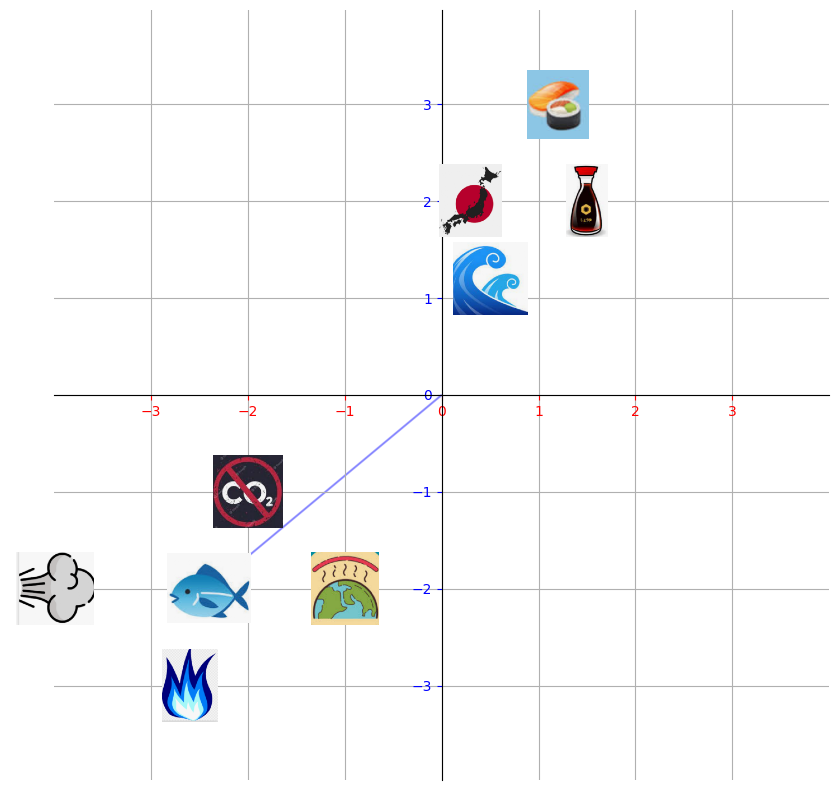

In [13]:
X_fish_neighbor_locations = np.array([
    [0.5, 1.2],     # Sea
    [1.2, 3.0],     # Sushi
    [1.5, 2.0],     # Soy source
    [0.3, 2.0]      # Japan
])
fish_neighbor_locations_img_paths = [
    '../image/sea.png',
    '../image/sushi.png',
    '../image/soy.png',
    '../image/japan.png',    
]

X_cow_neighbor_locations = np.array([
    [-2.0, -1.0],    # CO2
    [-4.0, -2.0],    # Fart
    [-1.0, -2.0],    # Global Warming
    [-2.6, -3.0]     # Gas
])
cow_neighbor_locations_img_paths = [
    '../image/co2.png',
    '../image/fart.png',
    '../image/warm.png',
    '../image/gas.png',    
]

fish_initial_location = np.average(X_cow_neighbor_locations, axis=0)
layout(fish_initial_location)

## Learn the embedding of **fish**

Keep getting closer to likes and away from non-likes

<img src="machine_learning_embedding.png"/>

In [18]:
def np_forward_propagate(w, X, T):
    """Forward propagation to calculate the loss (how far the vector is from the neighbors)
    Args:
        w: vector 
        X: neighbor vectors
        T: correct answers either 1: Yes or 0: No
    Returns: Scala loss value
    """
    N = len(X)
    # --------------------------------------------------------------------------------
    # Inner product X@W to measure similarities.
    # --------------------------------------------------------------------------------    
    Y = np.inner(w[np.newaxis, :], X)
    # --------------------------------------------------------------------------------
    # Logistic function
    # --------------------------------------------------------------------------------    
    Z = sigmoid(Y)
    # --------------------------------------------------------------------------------
    # Binary cross entropy log loss
    # --------------------------------------------------------------------------------
    L = binary_cross_entropy_log_loss(Z, T)
    return np.sum(L) / N

In [19]:
def gradient_descent(
    vector, 
    positive_neighbors, 
    positive_labels, 
    negative_neighbors, 
    negative_labels, 
    num_epochs, 
    lr, 
    ax=None
):
    w = copy.deepcopy(vector)
    L = []
    for i in range(0, NUM_EPOCH):
        # --------------------------------------------------------------------------------
        # Get the fish closer to positive neighbours
        # ----------------------------------|----------------------------------------------
        L.append(np_forward_propagate(w, positive_neighbors, positive_labels))
        w = w - lr * np_gradient(w, positive_neighbors, positive_labels)

        # --------------------------------------------------------------------------------
        # Get the fish away from negative neighbours
        # --------------------------------------------------------------------------------        
        L.append(np_forward_propagate(w, negative_neighbors, negative_labels))
        w = w - lr * np_gradient(w, negative_neighbors, negative_labels)
        
        # --------------------------------------------------------------------------------
        # Place the new vector
        # --------------------------------------------------------------------------------        
        plot_fish(ax, w, True)
        lr *= 0.985
        
    return w, L

In [20]:
LR = 0.05
NUM_EPOCH = 150

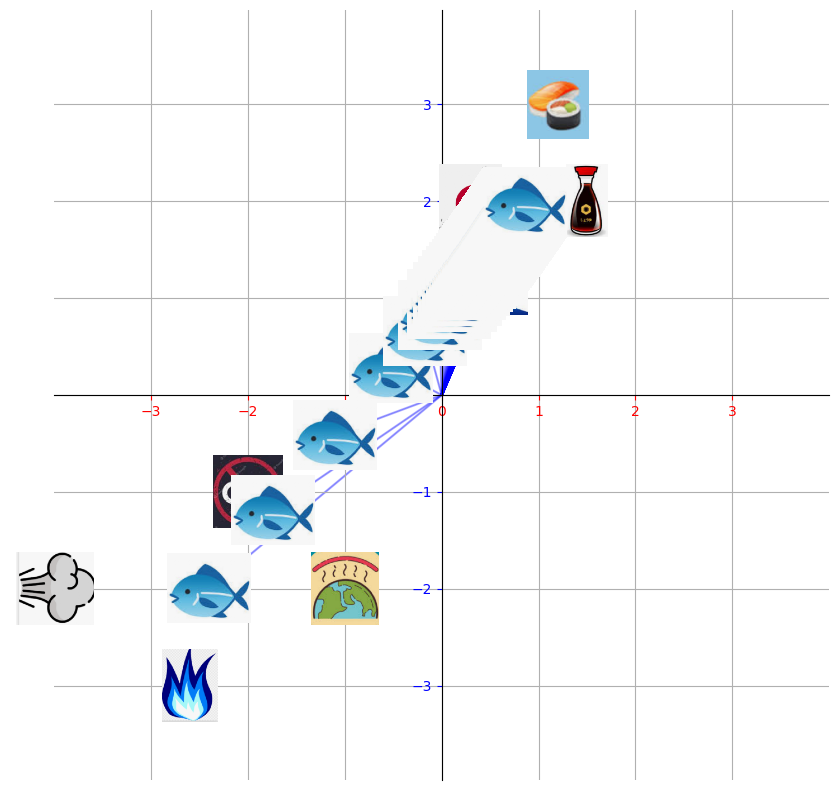

In [21]:
fix, ax = layout(fish_initial_location)
positive_labels = [1] * len(X_cow_neighbor_locations)
negative_labels = [0] * len(X_cow_neighbor_locations)

fish_location, L = gradient_descent(
    fish_initial_location, 
    X_fish_neighbor_locations, 
    positive_labels,
    X_cow_neighbor_locations, 
    negative_labels, 
    NUM_EPOCH, 
    LR, 
    ax
)

## Fish vector got trained to close to likes

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

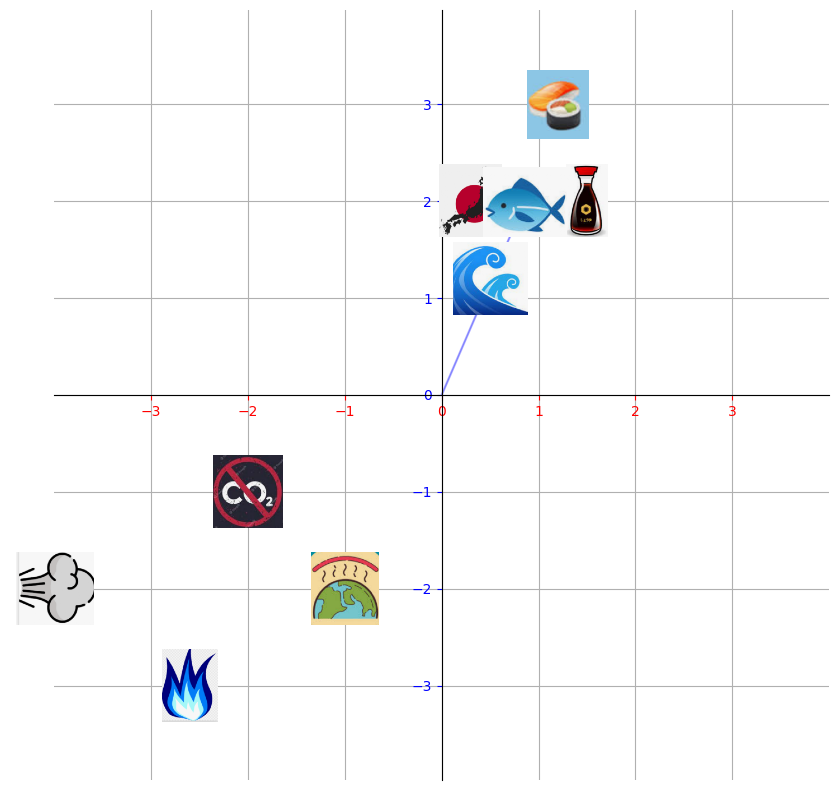

In [22]:
layout(fish_location)

---
## Training history 

In [ ]:
L